In [9]:
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import utils
from tqdm import tqdm
import warnings
import torchvision.models as models

warnings.simplefilter('ignore', Image.DecompressionBombWarning)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt

In [2]:
lr = 5e-4
n_epochs = 100
training_path = "/DAS_Storage4/hyungseok/Training"
validation_path = "/DAS_Storage4/hyungseok/Validation"


In [3]:
device = torch.device("cuda:0")

In [4]:
train_trans = transforms.Compose([transforms.Resize((128,128)),
                           transforms.ToTensor(),     
                           transforms.RandomHorizontalFlip(),
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])
valid_trans = transforms.Compose([transforms.Resize((128,128)),
                           transforms.ToTensor(),                           
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])
trainset = torchvision.datasets.ImageFolder(root = training_path,
                                           transform = train_trans)
validset = torchvision.datasets.ImageFolder(root = validation_path,
                                           transform = valid_trans)
train_loader = DataLoader(trainset, batch_size = 256, shuffle = True, num_workers = 4)
valid_loader = DataLoader(validset, batch_size = 256, shuffle = False, num_workers = 4)

In [5]:
model = models.resnet50(pretrained=False)
num_feature = model.fc.in_features
model.fc = nn.Linear(num_feature, 128)

In [6]:
model = model.to(device)
utils.init_weights(model, init_type='uniform')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (0.9, 0.98), eps = 1e-9, weight_decay = 1e-5)

In [7]:
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

for epoch in range(n_epochs):
    
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    running_val_loss = 0.0
    valid_correct = 0
    valid_total = 0
    model.train()
    
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        output = model(x)
        
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(output.data, 1)
        train_total += y.size(0)
        train_correct += (predicted == y).sum().item()
        
    with torch.no_grad():
        model.eval()

        for idx, (x, y) in tqdm(enumerate(valid_loader)):

            x, y = x.to(device), y.to(device)

            valid_output = model(x)

            valid_loss = criterion(valid_output, y)

            running_val_loss += valid_loss.item()

            _, predicted = torch.max(valid_output.data, 1)
            valid_total += y.size(0)
            valid_correct += (predicted == y).sum().item()
            
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : loss
    }, 'model/resnet/{}-resnet_model.pt'.format(epoch+1))


            
        
    print('Epoch {}/{}, Train_Acc: {:.3f}, Train_Loss : {:.6f}, valid_Acc : {:.3f}, Valid_Loss : {:.6f}'.format(epoch+1,n_epochs, 
                                                                                                              train_correct/train_total,
                                                                                                              running_loss / len(train_loader),
                                                                                                             valid_correct/valid_total,
                                                                                                              running_val_loss / len(valid_loader)
                                                                                                             ))
    
    train_loss_list.append(running_loss / len(train_loader))
    valid_loss_list.append(running_val_loss / len(valid_loader))
    train_acc_list.append(train_correct/train_total)
    valid_acc_list.append(valid_correct/valid_total)
    
        

2072it [1:37:37,  2.83s/it]
259it [12:07,  2.81s/it]


Epoch 1/100, Train_Acc: 0.397, Train_Loss : 2.509206, valid_Acc : 0.571, Valid_Loss : 1.642673


2072it [1:37:17,  2.82s/it]
259it [12:08,  2.81s/it]


Epoch 2/100, Train_Acc: 0.711, Train_Loss : 1.058712, valid_Acc : 0.741, Valid_Loss : 0.930560


2072it [1:37:21,  2.82s/it]
259it [12:06,  2.80s/it]


Epoch 3/100, Train_Acc: 0.815, Train_Loss : 0.643968, valid_Acc : 0.824, Valid_Loss : 0.615964


2072it [1:35:51,  2.78s/it]
259it [11:53,  2.76s/it]


Epoch 4/100, Train_Acc: 0.868, Train_Loss : 0.449229, valid_Acc : 0.837, Valid_Loss : 0.567253


2072it [1:36:34,  2.80s/it]
259it [12:20,  2.86s/it]


Epoch 5/100, Train_Acc: 0.899, Train_Loss : 0.334785, valid_Acc : 0.867, Valid_Loss : 0.457328


2072it [1:35:53,  2.78s/it]
259it [12:03,  2.79s/it]


Epoch 6/100, Train_Acc: 0.918, Train_Loss : 0.265237, valid_Acc : 0.891, Valid_Loss : 0.377421


2072it [1:37:05,  2.81s/it]
259it [12:49,  2.97s/it]


Epoch 7/100, Train_Acc: 0.932, Train_Loss : 0.218331, valid_Acc : 0.897, Valid_Loss : 0.346408


2072it [1:39:31,  2.88s/it]
259it [12:47,  2.97s/it]


Epoch 8/100, Train_Acc: 0.943, Train_Loss : 0.183618, valid_Acc : 0.909, Valid_Loss : 0.312518


2072it [1:39:03,  2.87s/it]
259it [12:04,  2.80s/it]


Epoch 9/100, Train_Acc: 0.949, Train_Loss : 0.161047, valid_Acc : 0.919, Valid_Loss : 0.275052


2072it [1:38:19,  2.85s/it]
259it [12:20,  2.86s/it]


Epoch 10/100, Train_Acc: 0.955, Train_Loss : 0.142328, valid_Acc : 0.919, Valid_Loss : 0.280483


2072it [1:42:28,  2.97s/it]
259it [12:01,  2.79s/it]


Epoch 11/100, Train_Acc: 0.959, Train_Loss : 0.129666, valid_Acc : 0.922, Valid_Loss : 0.271931


2072it [1:42:26,  2.97s/it]
259it [12:18,  2.85s/it]


Epoch 12/100, Train_Acc: 0.962, Train_Loss : 0.118344, valid_Acc : 0.928, Valid_Loss : 0.247639


2072it [1:40:40,  2.92s/it]
259it [12:05,  2.80s/it]


Epoch 13/100, Train_Acc: 0.965, Train_Loss : 0.110032, valid_Acc : 0.933, Valid_Loss : 0.231317


2072it [1:39:05,  2.87s/it]
259it [12:18,  2.85s/it]


Epoch 14/100, Train_Acc: 0.967, Train_Loss : 0.102711, valid_Acc : 0.939, Valid_Loss : 0.214343


2072it [1:38:37,  2.86s/it]
259it [12:03,  2.79s/it]


Epoch 15/100, Train_Acc: 0.969, Train_Loss : 0.097294, valid_Acc : 0.937, Valid_Loss : 0.219594


2072it [1:39:15,  2.87s/it]
259it [12:13,  2.83s/it]


Epoch 16/100, Train_Acc: 0.971, Train_Loss : 0.091771, valid_Acc : 0.943, Valid_Loss : 0.200671


2072it [1:38:41,  2.86s/it]
259it [12:20,  2.86s/it]


Epoch 17/100, Train_Acc: 0.972, Train_Loss : 0.087521, valid_Acc : 0.931, Valid_Loss : 0.247040


2072it [1:39:16,  2.87s/it]
259it [12:43,  2.95s/it]


Epoch 18/100, Train_Acc: 0.973, Train_Loss : 0.084353, valid_Acc : 0.948, Valid_Loss : 0.180971


2072it [1:39:34,  2.88s/it]
259it [12:07,  2.81s/it]


Epoch 19/100, Train_Acc: 0.974, Train_Loss : 0.080256, valid_Acc : 0.940, Valid_Loss : 0.213081


2072it [1:39:16,  2.87s/it]
259it [13:07,  3.04s/it]


Epoch 20/100, Train_Acc: 0.975, Train_Loss : 0.078070, valid_Acc : 0.945, Valid_Loss : 0.196717


2072it [1:43:04,  2.98s/it]
259it [12:08,  2.81s/it]


Epoch 21/100, Train_Acc: 0.976, Train_Loss : 0.074283, valid_Acc : 0.944, Valid_Loss : 0.200594


2072it [1:41:54,  2.95s/it]
259it [13:46,  3.19s/it]


Epoch 22/100, Train_Acc: 0.977, Train_Loss : 0.072745, valid_Acc : 0.953, Valid_Loss : 0.167745


2072it [1:42:55,  2.98s/it]
259it [12:12,  2.83s/it]


Epoch 23/100, Train_Acc: 0.977, Train_Loss : 0.071142, valid_Acc : 0.944, Valid_Loss : 0.198775


2072it [1:38:27,  2.85s/it]
259it [12:32,  2.91s/it]


Epoch 24/100, Train_Acc: 0.978, Train_Loss : 0.069569, valid_Acc : 0.955, Valid_Loss : 0.161020


2072it [1:36:50,  2.80s/it]
259it [12:21,  2.86s/it]


Epoch 25/100, Train_Acc: 0.979, Train_Loss : 0.067177, valid_Acc : 0.954, Valid_Loss : 0.161816


2072it [1:37:39,  2.83s/it]
259it [12:27,  2.89s/it]


Epoch 26/100, Train_Acc: 0.979, Train_Loss : 0.065242, valid_Acc : 0.949, Valid_Loss : 0.186551


2072it [1:39:00,  2.87s/it]
259it [12:22,  2.87s/it]


Epoch 27/100, Train_Acc: 0.980, Train_Loss : 0.063334, valid_Acc : 0.942, Valid_Loss : 0.210107


2072it [1:37:44,  2.83s/it]
259it [12:34,  2.91s/it]


Epoch 28/100, Train_Acc: 0.980, Train_Loss : 0.062128, valid_Acc : 0.954, Valid_Loss : 0.163794


2072it [1:38:33,  2.85s/it]
259it [12:22,  2.87s/it]


Epoch 29/100, Train_Acc: 0.981, Train_Loss : 0.060974, valid_Acc : 0.954, Valid_Loss : 0.166623


2072it [1:37:50,  2.83s/it]
259it [12:07,  2.81s/it]


Epoch 30/100, Train_Acc: 0.981, Train_Loss : 0.060194, valid_Acc : 0.952, Valid_Loss : 0.177587


2072it [1:40:00,  2.90s/it]
259it [12:25,  2.88s/it]


Epoch 31/100, Train_Acc: 0.981, Train_Loss : 0.058789, valid_Acc : 0.959, Valid_Loss : 0.148973


2072it [1:38:28,  2.85s/it]
259it [12:27,  2.88s/it]


Epoch 32/100, Train_Acc: 0.982, Train_Loss : 0.058333, valid_Acc : 0.956, Valid_Loss : 0.159479


2072it [1:38:10,  2.84s/it]
259it [12:27,  2.89s/it]


Epoch 33/100, Train_Acc: 0.982, Train_Loss : 0.056359, valid_Acc : 0.958, Valid_Loss : 0.148941


2072it [1:38:16,  2.85s/it]
259it [12:26,  2.88s/it]


Epoch 34/100, Train_Acc: 0.982, Train_Loss : 0.055770, valid_Acc : 0.956, Valid_Loss : 0.161189


2072it [1:37:02,  2.81s/it]
259it [12:33,  2.91s/it]


Epoch 35/100, Train_Acc: 0.983, Train_Loss : 0.054644, valid_Acc : 0.960, Valid_Loss : 0.140092


2072it [1:39:06,  2.87s/it]
259it [12:07,  2.81s/it]


Epoch 36/100, Train_Acc: 0.983, Train_Loss : 0.053657, valid_Acc : 0.957, Valid_Loss : 0.159018


2072it [1:37:44,  2.83s/it]
259it [12:25,  2.88s/it]


Epoch 37/100, Train_Acc: 0.983, Train_Loss : 0.053117, valid_Acc : 0.954, Valid_Loss : 0.168588


2072it [1:38:08,  2.84s/it]
259it [12:31,  2.90s/it]


Epoch 38/100, Train_Acc: 0.983, Train_Loss : 0.052586, valid_Acc : 0.955, Valid_Loss : 0.159108


2072it [1:38:05,  2.84s/it]
259it [12:34,  2.91s/it]


Epoch 39/100, Train_Acc: 0.984, Train_Loss : 0.051626, valid_Acc : 0.964, Valid_Loss : 0.134491


2072it [1:38:46,  2.86s/it]
259it [12:14,  2.84s/it]


Epoch 40/100, Train_Acc: 0.984, Train_Loss : 0.050346, valid_Acc : 0.960, Valid_Loss : 0.143158


2072it [1:37:34,  2.83s/it]
259it [12:21,  2.86s/it]


Epoch 41/100, Train_Acc: 0.984, Train_Loss : 0.050610, valid_Acc : 0.961, Valid_Loss : 0.138273


2072it [1:37:47,  2.83s/it]
259it [12:27,  2.89s/it]


Epoch 42/100, Train_Acc: 0.985, Train_Loss : 0.049014, valid_Acc : 0.959, Valid_Loss : 0.144659


2072it [1:37:23,  2.82s/it]
259it [12:29,  2.89s/it]


Epoch 43/100, Train_Acc: 0.985, Train_Loss : 0.048542, valid_Acc : 0.961, Valid_Loss : 0.140093


2072it [1:38:09,  2.84s/it]
259it [12:25,  2.88s/it]


Epoch 44/100, Train_Acc: 0.985, Train_Loss : 0.048004, valid_Acc : 0.961, Valid_Loss : 0.145271


2072it [1:37:18,  2.82s/it]
259it [12:57,  3.00s/it]


Epoch 45/100, Train_Acc: 0.985, Train_Loss : 0.047586, valid_Acc : 0.963, Valid_Loss : 0.136113


2072it [1:37:29,  2.82s/it]
259it [12:46,  2.96s/it]


Epoch 46/100, Train_Acc: 0.985, Train_Loss : 0.046684, valid_Acc : 0.962, Valid_Loss : 0.133845


2072it [1:38:03,  2.84s/it]
259it [12:28,  2.89s/it]


Epoch 47/100, Train_Acc: 0.985, Train_Loss : 0.046567, valid_Acc : 0.961, Valid_Loss : 0.141524


2072it [1:37:36,  2.83s/it]
259it [12:53,  2.99s/it]


Epoch 48/100, Train_Acc: 0.986, Train_Loss : 0.045449, valid_Acc : 0.957, Valid_Loss : 0.154741


2072it [1:37:24,  2.82s/it]
259it [12:31,  2.90s/it]


Epoch 49/100, Train_Acc: 0.986, Train_Loss : 0.044740, valid_Acc : 0.962, Valid_Loss : 0.138368


2072it [1:38:02,  2.84s/it]
259it [12:41,  2.94s/it]


Epoch 50/100, Train_Acc: 0.986, Train_Loss : 0.044892, valid_Acc : 0.964, Valid_Loss : 0.130794


2072it [1:38:00,  2.84s/it]
259it [12:22,  2.87s/it]


Epoch 51/100, Train_Acc: 0.986, Train_Loss : 0.044687, valid_Acc : 0.961, Valid_Loss : 0.144920


2072it [1:37:51,  2.83s/it]
259it [12:30,  2.90s/it]


Epoch 52/100, Train_Acc: 0.986, Train_Loss : 0.044299, valid_Acc : 0.962, Valid_Loss : 0.134077


2072it [1:37:35,  2.83s/it]
259it [12:58,  3.01s/it]


Epoch 53/100, Train_Acc: 0.987, Train_Loss : 0.042732, valid_Acc : 0.966, Valid_Loss : 0.123539


2072it [1:37:37,  2.83s/it]
259it [12:36,  2.92s/it]


Epoch 54/100, Train_Acc: 0.986, Train_Loss : 0.043629, valid_Acc : 0.963, Valid_Loss : 0.136017


2072it [1:37:45,  2.83s/it]
259it [12:26,  2.88s/it]


Epoch 55/100, Train_Acc: 0.987, Train_Loss : 0.043249, valid_Acc : 0.961, Valid_Loss : 0.140453


2072it [1:37:53,  2.83s/it]
259it [12:39,  2.93s/it]


Epoch 56/100, Train_Acc: 0.987, Train_Loss : 0.041937, valid_Acc : 0.962, Valid_Loss : 0.134762


2072it [1:38:31,  2.85s/it]
259it [12:32,  2.91s/it]


Epoch 57/100, Train_Acc: 0.987, Train_Loss : 0.041807, valid_Acc : 0.961, Valid_Loss : 0.138176


2072it [1:37:43,  2.83s/it]
259it [12:33,  2.91s/it]


Epoch 58/100, Train_Acc: 0.987, Train_Loss : 0.042077, valid_Acc : 0.966, Valid_Loss : 0.119520


2072it [1:37:11,  2.81s/it]
259it [12:18,  2.85s/it]


Epoch 59/100, Train_Acc: 0.987, Train_Loss : 0.041524, valid_Acc : 0.966, Valid_Loss : 0.126114


2072it [1:36:46,  2.80s/it]
259it [12:24,  2.87s/it]


Epoch 60/100, Train_Acc: 0.987, Train_Loss : 0.041233, valid_Acc : 0.966, Valid_Loss : 0.124540


2072it [1:37:13,  2.82s/it]
259it [12:51,  2.98s/it]


Epoch 61/100, Train_Acc: 0.988, Train_Loss : 0.039775, valid_Acc : 0.964, Valid_Loss : 0.131449


2072it [1:40:21,  2.91s/it]
259it [12:25,  2.88s/it]


Epoch 62/100, Train_Acc: 0.987, Train_Loss : 0.040466, valid_Acc : 0.966, Valid_Loss : 0.127149


2072it [1:36:26,  2.79s/it]
259it [12:20,  2.86s/it]


Epoch 63/100, Train_Acc: 0.988, Train_Loss : 0.039977, valid_Acc : 0.965, Valid_Loss : 0.131175


2072it [1:36:52,  2.81s/it]
259it [12:06,  2.81s/it]


Epoch 64/100, Train_Acc: 0.987, Train_Loss : 0.039833, valid_Acc : 0.962, Valid_Loss : 0.137106


2072it [1:36:08,  2.78s/it]
259it [12:28,  2.89s/it]


Epoch 65/100, Train_Acc: 0.988, Train_Loss : 0.039381, valid_Acc : 0.967, Valid_Loss : 0.120518


2072it [1:35:59,  2.78s/it]
259it [12:09,  2.82s/it]


Epoch 66/100, Train_Acc: 0.988, Train_Loss : 0.039613, valid_Acc : 0.964, Valid_Loss : 0.130410


2072it [1:37:39,  2.83s/it]
259it [12:19,  2.86s/it]


Epoch 67/100, Train_Acc: 0.988, Train_Loss : 0.038746, valid_Acc : 0.967, Valid_Loss : 0.123282


2072it [1:36:39,  2.80s/it]
259it [12:22,  2.87s/it]


Epoch 68/100, Train_Acc: 0.988, Train_Loss : 0.038434, valid_Acc : 0.967, Valid_Loss : 0.122000


2072it [1:36:43,  2.80s/it]
259it [12:17,  2.85s/it]


Epoch 69/100, Train_Acc: 0.988, Train_Loss : 0.038806, valid_Acc : 0.969, Valid_Loss : 0.113277


2072it [1:37:00,  2.81s/it]
259it [12:07,  2.81s/it]


Epoch 70/100, Train_Acc: 0.988, Train_Loss : 0.037766, valid_Acc : 0.967, Valid_Loss : 0.118300


2072it [1:36:32,  2.80s/it]
259it [12:19,  2.85s/it]


Epoch 71/100, Train_Acc: 0.988, Train_Loss : 0.037711, valid_Acc : 0.967, Valid_Loss : 0.122231


2072it [1:36:50,  2.80s/it]
259it [12:12,  2.83s/it]


Epoch 72/100, Train_Acc: 0.988, Train_Loss : 0.037589, valid_Acc : 0.967, Valid_Loss : 0.122573


2072it [1:38:05,  2.84s/it]
259it [12:03,  2.79s/it]


Epoch 73/100, Train_Acc: 0.988, Train_Loss : 0.037792, valid_Acc : 0.966, Valid_Loss : 0.125292


2072it [1:39:10,  2.87s/it]
259it [12:10,  2.82s/it]


Epoch 74/100, Train_Acc: 0.989, Train_Loss : 0.037069, valid_Acc : 0.969, Valid_Loss : 0.113861


2072it [1:38:02,  2.84s/it]
259it [12:06,  2.81s/it]


Epoch 75/100, Train_Acc: 0.988, Train_Loss : 0.037458, valid_Acc : 0.965, Valid_Loss : 0.126307


2072it [1:54:29,  3.32s/it]
259it [12:45,  2.96s/it]


Epoch 76/100, Train_Acc: 0.989, Train_Loss : 0.036612, valid_Acc : 0.964, Valid_Loss : 0.134944


2072it [1:40:34,  2.91s/it]
259it [12:16,  2.84s/it]


Epoch 77/100, Train_Acc: 0.989, Train_Loss : 0.036537, valid_Acc : 0.962, Valid_Loss : 0.138655


2072it [1:40:18,  2.90s/it]
259it [13:41,  3.17s/it]


Epoch 78/100, Train_Acc: 0.989, Train_Loss : 0.036004, valid_Acc : 0.969, Valid_Loss : 0.115000


2072it [1:39:22,  2.88s/it]
259it [12:15,  2.84s/it]


Epoch 79/100, Train_Acc: 0.989, Train_Loss : 0.036185, valid_Acc : 0.966, Valid_Loss : 0.124421


2072it [1:39:27,  2.88s/it]
259it [12:17,  2.85s/it]


Epoch 80/100, Train_Acc: 0.989, Train_Loss : 0.036803, valid_Acc : 0.966, Valid_Loss : 0.124918


2072it [1:38:05,  2.84s/it]
259it [12:21,  2.86s/it]


Epoch 81/100, Train_Acc: 0.989, Train_Loss : 0.035469, valid_Acc : 0.970, Valid_Loss : 0.107885


2072it [1:37:28,  2.82s/it]
259it [12:25,  2.88s/it]


Epoch 82/100, Train_Acc: 0.989, Train_Loss : 0.035505, valid_Acc : 0.966, Valid_Loss : 0.122239


2072it [1:38:07,  2.84s/it]
259it [12:52,  2.98s/it]


Epoch 83/100, Train_Acc: 0.989, Train_Loss : 0.035518, valid_Acc : 0.968, Valid_Loss : 0.117705


2072it [1:37:02,  2.81s/it]
259it [12:39,  2.93s/it]


Epoch 84/100, Train_Acc: 0.989, Train_Loss : 0.034898, valid_Acc : 0.969, Valid_Loss : 0.116280


2072it [1:38:49,  2.86s/it]
259it [12:24,  2.87s/it]


Epoch 85/100, Train_Acc: 0.989, Train_Loss : 0.035024, valid_Acc : 0.966, Valid_Loss : 0.125379


2072it [1:39:18,  2.88s/it]
259it [12:16,  2.85s/it]


Epoch 86/100, Train_Acc: 0.989, Train_Loss : 0.035439, valid_Acc : 0.968, Valid_Loss : 0.119272


1889it [1:34:15,  2.99s/it]


KeyboardInterrupt: 

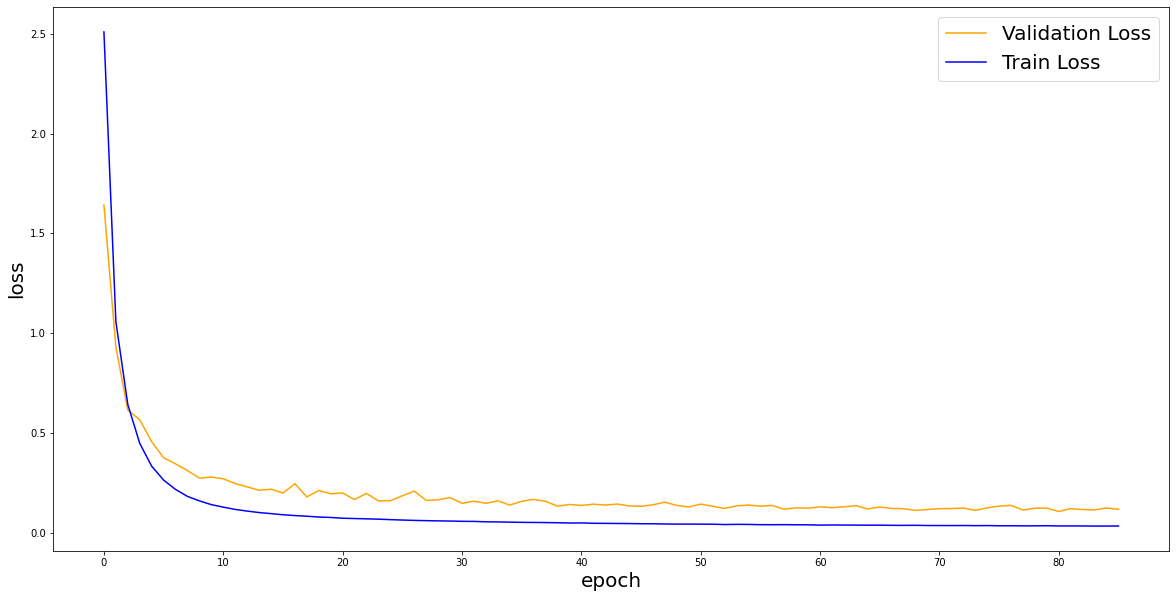

In [10]:
x_len = np.arange(len(valid_loss_list))
plt.figure(figsize=(20,10))
plt.plot(x_len, valid_loss_list, c='orange', label="Validation Loss")
plt.plot(x_len, train_loss_list, c='blue', label="Train Loss")
plt.xticks(np.arange(0, 90, 10))
#plt.title('With pretraining', fontsize=20)
plt.legend(loc='upper right')
plt.legend(loc='best', ncol=1, fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

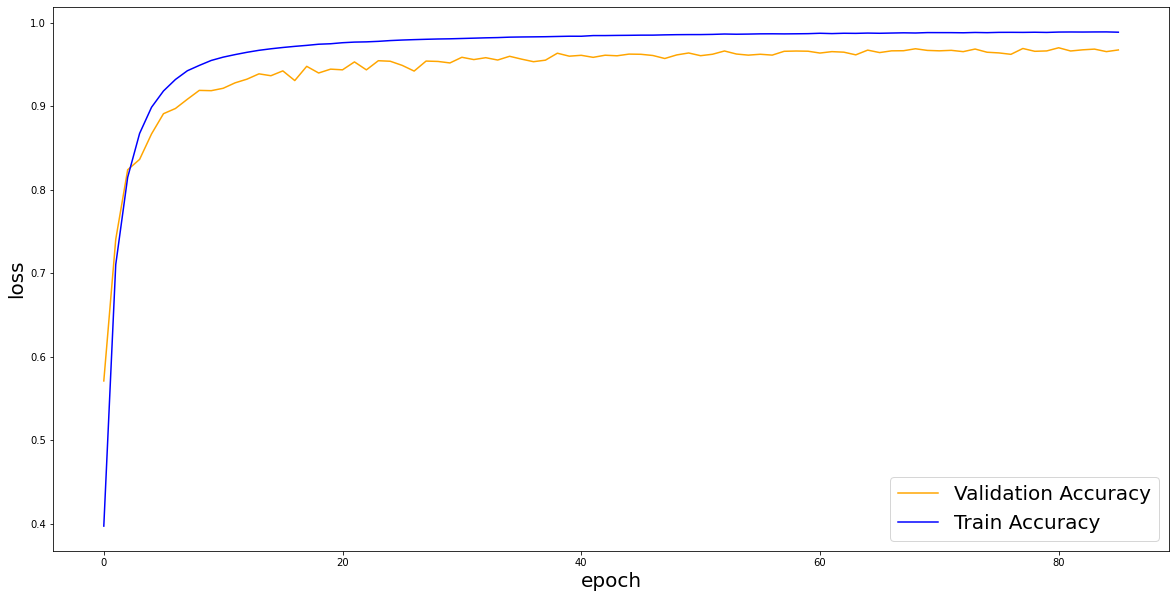

In [12]:
x_len = np.arange(len(valid_acc_list))
plt.figure(figsize=(20,10))
plt.plot(x_len, valid_acc_list, c='orange', label="Validation Accuracy")
plt.plot(x_len, train_acc_list, c='blue', label="Train Accuracy")
#plt.title('With pretraining', fontsize=20)
plt.legend(loc='upper right')
plt.legend(loc='best', ncol=1, fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()